In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        
    def forward(self, trace):
        z = trace.sample('z', np.random.rand, 3)
        x = trace.sample('x', lambda z: z + np.random.randn(3)*0.02, z)

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-3)
        self.classifier = swyft.RatioEstimatorMLP1d(3, 3, hidden_features = 256, dropout = 0.1)
        
    def forward(self, x, z):
        x = x['x']
        z = z['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [5]:
simulator = Simulator()
noise_hook = simulator.get_resampler(['x'])

In [6]:
shapes, dtypes = simulator.get_shapes_and_dtypes()
zs = swyft.ZarrStore("./03-minimal-zarr.zarr")
zs.init(10000, 32, shapes = shapes, dtypes = dtypes)
zs.simulate(simulator, batch_size = 500)

In [7]:
dl_train = zs.get_dataloader(num_workers = 3, batch_size = 128, on_after_load_sample = noise_hook, idx_range = [0, 9000])
dl_valid = zs.get_dataloader(num_workers = 3, batch_size = 128, on_after_load_sample = noise_hook, idx_range = [9000, 10000])

In [8]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 3, **swyft.tensorboard_config(name = '01-minimal-example', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
network = Network()

In [10]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLP1d | 800 K 
---------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)


Epoch 0: : 69it [00:01, 53.78it/s, loss=-2.97, v_num=1]               
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 0: : 76it [00:01, 46.04it/s, loss=-2.97, v_num=1, val_loss=-2.76]
Epoch 1: : 69it [00:01, 56.72it/s, loss=-3.04, v_num=1, val_loss=-2.76]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 76it [00:01, 49.16it/s, loss=-3.04, v_num=1, val_loss=-2.98]
Epoch 2: : 69it [00:01, 60.11it/s, loss=-3.15, v_num=1, val_loss=-2.98]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2: : 76it [00:01, 48.42it/s, loss=-3.15, v_num=1, val_loss=-3.08]
Epoch 2: : 77it [00:01, 47.58it/s, loss=-3.15, v_num=1, val_loss=-3.08]


In [11]:
trainer.test(network, dl_valid, ckpt_path = 'best')

Restoring states from the checkpoint path at ./lightning_logs/01-minimal-example/version_1/checkpoints/epoch=2-step=206.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/01-minimal-example/version_1/checkpoints/epoch=2-step=206.ckpt


Testing: 1it [00:00,  3.54it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': -3.0239827632904053, 'hp/KL-div': -6.544938564300537}
--------------------------------------------------------------------------------
Testing: 7it [00:00, 18.89it/s]


[{'hp/JS-div': -3.0239827632904053, 'hp/KL-div': -6.544938564300537}]

In [12]:
x0 = [0.3, 0.5, 0.7]
prior_samples = simulator(1000000, targets = ['z'])

100%|██████████| 1000000/1000000 [00:10<00:00, 91241.25it/s]


In [13]:
predictions = trainer.infer(network, {'x': torch.tensor(x0)}, prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting:   8%|▊         | 76/977 [00:00<00:12, 69.66it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 100%|██████████| 977/977 [00:15<00:00, 58.81it/s]


In [14]:
post_samples = predictions.sample(100000)

0.019565418
0.022611797
0.020936947


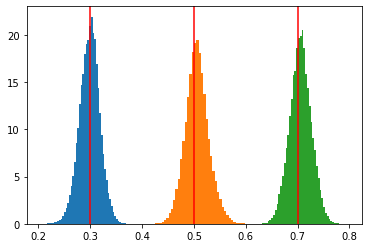

In [15]:
import pylab as plt
for i in range(3):
    s = post_samples['z'][:,i].numpy()
    print(s.std())
    plt.hist(s, bins = 50, density=True);
    plt.axvline(x0[i], color='r')